<a href="https://colab.research.google.com/github/MaorKer/Wiezmann_ML_Course/blob/HW3/Maor_Kereth_Homework_3_point_cloud_mnist.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [2]:
#if youre running on colab, run this line first to properly load the h5 files
!pip install tables --upgrade

     |████████████████████████████████| 4.3MB 3.4MB/s 
  Found existing installation: tables 3.4.4
    Uninstalling tables-3.4.4:
      Successfully uninstalled tables-3.4.4


In [3]:
import torch
import torch.nn as nn
import torch.nn.functional as F
from torch.utils.data import Dataset, DataLoader, Sampler
import glob
from tqdm.notebook import tqdm
import torch.optim as optim
import pandas as pd
import matplotlib.pyplot as plt
import numpy as np

# Homework 3
## Point Cloud MNIST with DeepSet


below you have a custom dataloader for the point-cloud MNIST dataset,

the training and validation datasets are linked from the course website

In [4]:
class CustomDataset(Dataset):
    def __init__(self, path):
        

        
        self.df = pd.read_hdf(path)
        
        self.label = torch.LongTensor(self.df.label)
        
        self.n_points = self.df.n_points
        
        
    def __len__(self):
       
        return len(self.label)


    def __getitem__(self, idx):
        
    
        return torch.FloatTensor(self.df.iloc[idx].xy), self.label[idx]

In [ ]:
ds.label.unique().size()

torch.Size([10])

#### the data is exactly like the MNIST dataset, except that instead of a 28x28 image,
#### you get a (N x 2) array of points (different number of points for each item in the dataset) 

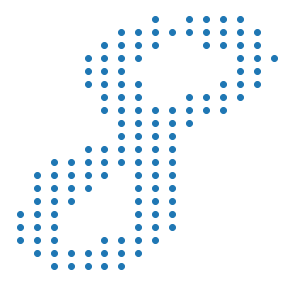

In [ ]:
fig,ax = plt.subplots(figsize=(5,5))

xy = ds[445][0]

ax.scatter( xy[:,0],xy[:,1] )

ax.set_axis_off()

plt.show()

### the dataset object has a n_points variable that tells us how many points in each item

In [ ]:
ds.n_points

0       117
1       130
2        88
3        70
4        97
       ... 
9995    120
9996    111
9997    114
9998     81
9999     88
Name: n_points, Length: 10000, dtype: object

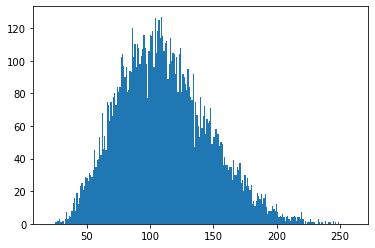

In [ ]:
plt.hist(ds.n_points,np.linspace(19.5,260.5,242))
plt.show()

## One way to deal with this variable size is to use a custom Batch Sampler

https://pytorch.org/docs/stable/data.html

This object will tell our dataloader which item indices to request for the batches - 
and we can "rig" it to return batches where all the items have the same N, and therefore we can stack them without a custom colate function

In [5]:
class CustomBatchSampler(Sampler):
    def __init__(self, points_per_entry, batch_size):
        
        self.batch_size = batch_size
        self.N_per_entry = points_per_entry
        self.batches = {}
        
    def generate_batches(self):
        
        self.entries_with_N = {}
        running_idx = -1

        for N in set(self.N_per_entry):
            
            self.entries_with_N[N] = np.where(self.N_per_entry == N)[0]

            how_many = len(self.entries_with_N[N])
            n_batches = np.amax([ how_many / self.batch_size, 1])

            self.entries_with_N[N] = np.array_split(np.random.permutation(self.entries_with_N[N]),
                                                           n_batches)
            for batch in self.entries_with_N[N]:
                running_idx += 1
                self.batches[running_idx] = batch

        self.n_batches = running_idx + 1

    def __len__(self):
        return self.n_batches

    def __iter__(self):
        
        self.generate_batches()
        
        batch_order = np.random.permutation(np.arange(self.n_batches))
        for i in batch_order:
            yield self.batches[i]

## Building a DeepSet model

you only have three components - a fully connected network that creates the node embedding, a sum operation, and a classifier

In [ ]:
# the linear layer operates on the last dimension:

linear_layer = nn.Linear(10,5)

linear_layer(  torch.rand((345,10)) ).shape, linear_layer(  torch.rand((345,76,10)) ).shape

(torch.Size([345, 5]), torch.Size([345, 76, 5]))

In [ ]:
# for the the mean operation you need to specify the dimension:

x = torch.rand((42,15,10))

torch.mean(x,dim=1).shape   

torch.Size([42, 10])

## build the model, train, submit when you reach above 75% accuracy on the validation set:

In [6]:
class DeepSet(nn.Module):
    def __init__(self):
        super(DeepSet, self).__init__()
        self.linear_emb=nn.Linear(2,8)  #shape - (n_pictues_inbatch,n.points,8)
        self.linear_emb2=nn.Linear(8,16)  
        self.linear_emb3=nn.Linear(16,64)  
        self.linear_emb4=nn.Linear(64,128)  

        self.linear1=nn.Linear(128,16)
        self.linear2=nn.Linear(16,10)
    
    def forward(self, x):
        x = F.relu(self.linear_emb(x))
        x = F.relu(self.linear_emb2(x))
        x = F.relu(self.linear_emb3(x))
        x = F.relu(self.linear_emb4(x))

        x = torch.mean(x,1)

        x = F.relu(self.linear1(x))
        output = self.linear2(x)
        
        return output 

In [27]:
net = DeepSet()
# net.cuda()
loss_func = nn.CrossEntropyLoss()
optimizer = optim.Adam(net.parameters(), lr=1e-4)

In [28]:
def compute_accuracy(data_loader,net):
    
    net.eval()
    
    total_number = 0
    total_correct = 0
    
    for x,y in data_loader:
        x, y = x.cpu(), y.cpu()

        prediction = net(x).data.numpy()
        
        prediction = np.argmax(prediction,axis=1)
        
        correct = len( np.where(prediction==y.data.numpy())[0] )
        
        total_correct+=correct
        total_number+=x.shape[0]
        
    return total_correct/float(total_number)

In [29]:
def compute_loss(data_loader,net, loss_func):
    
    net.eval()
    
    total_number = 0
    sizes = []
    losses = []
    
    for x,y in data_loader:
        x, y = x.cpu(), y.cpu()
        logits = net(x)
        loss = loss_func(logits, y)
        sizes.append(x.shape[0])
        losses.append(loss.cpu().item())
        total_number+=x.shape[0]

    mean_loss = 0
    for loss, size in zip(losses, sizes):
        mean_loss += loss * size
    mean_loss /= total_number
    print(losses)

    # mean_loss = sum([loss * size for loss, size in zip(losses, sizes)]) / total_number
        
    return mean_loss

In [30]:


batch_size = 50
ds_train = CustomDataset('/content/drive/My Drive/ML Weizmann/training_ds.h5')
ds_val = CustomDataset('/content/drive/My Drive/ML Weizmann/valid_ds.h5')

batch_sampler_train = CustomBatchSampler(ds_train.n_points, batch_size)
train_data_loader = DataLoader(ds_train, batch_sampler=batch_sampler_train)

batch_sampler_val = CustomBatchSampler(ds_val.n_points, batch_size)
val_data_loader = DataLoader(ds_val, batch_sampler=batch_sampler_val)



In [31]:
train_accs = []
val_accs = []
train_losses = []
val_losses = []
n_epochs=10

for epoch in tqdm(range(n_epochs)):

    net.train()
    for x, y in tqdm(train_data_loader):
        x, y = x.cpu(), y.cpu()
        logits = net(x)
        loss = loss_func(logits, y)
        optimizer.zero_grad()
        loss.backward()
        optimizer.step()
# if epoch > 90 :
    train_accs.append(compute_accuracy(train_data_loader, net))
    val_accs.append(compute_accuracy(val_data_loader, net))
    train_losses.append(compute_loss(train_data_loader, net, loss_func))
    val_losses.append(compute_loss(val_data_loader, net, loss_func))


[2.330902338027954, 2.3645405769348145, 2.2484564781188965, 2.437938690185547, 2.3123691082000732, 2.355701208114624, 2.3551557064056396, 2.226735830307007, 2.2067415714263916, 2.3551509380340576, 2.2897863388061523, 2.298488140106201, 2.309196949005127, 2.366075277328491, 2.308530330657959, 2.3356306552886963, 2.3007586002349854, 2.273648500442505, 2.3774027824401855, 2.3581745624542236, 2.126621723175049, 2.251650094985962, 2.2260901927948, 2.2807633876800537, 2.327758312225342, 2.4366981983184814, 2.4287757873535156, 2.2398414611816406, 2.327885150909424, 2.277331829071045, 2.4140777587890625, 2.3834807872772217, 2.295227527618408, 2.3540186882019043, 2.3699843883514404, 2.3476450443267822, 2.294219732284546, 2.226613759994507, 2.348483085632324, 2.2267446517944336, 2.3121674060821533, 2.3441126346588135, 2.2228689193725586, 2.346759557723999, 2.4367973804473877, 2.3489835262298584, 2.261746644973755, 2.3609673976898193, 2.436859130859375, 2.358022928237915, 2.348876714706421, 2.24


[2.184598207473755, 2.2267394065856934, 2.2805213928222656, 2.3056819438934326, 2.4023592472076416, 2.1634998321533203, 2.340038299560547, 2.2778477668762207, 2.1842880249023438, 2.303373336791992, 2.164884328842163, 2.2559244632720947, 2.298598527908325, 2.264965772628784, 2.314847946166992, 2.3331472873687744, 2.339711904525757, 2.2309906482696533, 2.4197213649749756, 2.3234148025512695, 2.1843762397766113, 2.2773396968841553, 2.377060890197754, 2.313838243484497, 2.282660961151123, 2.165081262588501, 2.372145414352417, 2.3734564781188965, 2.3153319358825684, 2.314202308654785, 2.311220645904541, 2.1649422645568848, 2.237213134765625, 2.3157918453216553, 2.3486380577087402, 2.3423938751220703, 2.341062545776367, 2.348217725753784, 2.3828744888305664, 2.397433280944824, 2.1648876667022705, 2.262406826019287, 2.310413360595703, 2.3162615299224854, 2.3321077823638916, 2.3162057399749756, 2.3594555854797363, 2.3355231285095215, 2.2781033515930176, 2.195265054702759, 2.360701322555542, 2


[2.169797897338867, 2.3532376289367676, 2.3602287769317627, 2.2626333236694336, 2.1865217685699463, 2.379336357116699, 2.2895898818969727, 2.3267641067504883, 2.312469720840454, 2.340663433074951, 2.3438949584960938, 2.3646440505981445, 2.262911319732666, 2.361855983734131, 2.2943520545959473, 2.3322441577911377, 2.3365061283111572, 2.3403570652008057, 2.18717360496521, 2.1886167526245117, 2.323021411895752, 2.35252046585083, 2.1814956665039062, 2.2731618881225586, 2.05893611907959, 2.217535972595215, 2.329378604888916, 2.323678731918335, 2.1256372928619385, 2.3441975116729736, 2.323715925216675, 2.27079701423645, 2.3727428913116455, 2.300832748413086, 2.321593761444092, 2.2101199626922607, 2.3551180362701416, 2.3614022731781006, 2.0440192222595215, 2.37961483001709, 2.3510942459106445, 2.3325600624084473, 2.36582088470459, 2.368375301361084, 2.28420090675354, 2.3421688079833984, 2.1888551712036133, 2.3442606925964355, 2.133516311645508, 2.351090669631958, 2.334298610687256, 2.3853158


[2.3129961490631104, 2.397580862045288, 2.4266600608825684, 1.909409999847412, 2.177541494369507, 1.8595037460327148, 2.062110185623169, 2.2701165676116943, 2.434804677963257, 2.372563600540161, 2.251291513442993, 2.378451347351074, 2.340092182159424, 2.295325756072998, 1.9105234146118164, 2.2490954399108887, 2.1525495052337646, 2.0951144695281982, 2.341923713684082, 2.455876111984253, 2.383542537689209, 2.426280975341797, 2.308800220489502, 2.347022533416748, 2.1421139240264893, 1.862916350364685, 2.120774984359741, 2.3915653228759766, 2.059770107269287, 1.8632805347442627, 2.2218475341796875, 2.2987072467803955, 2.3593549728393555, 2.4180102348327637, 2.3632376194000244, 2.3867135047912598, 2.180372714996338, 1.9132291078567505, 2.2269582748413086, 1.9111086130142212, 2.345322608947754, 1.8634998798370361, 2.294591188430786, 1.9122796058654785, 2.3536794185638428, 2.2906434535980225, 2.2568840980529785, 2.255725145339966, 1.9105790853500366, 2.040580987930298, 2.3997318744659424, 2.


[2.4157803058624268, 1.8639180660247803, 2.409003496170044, 2.3491406440734863, 1.740302324295044, 2.4676733016967773, 2.4332361221313477, 2.4995572566986084, 2.1549320220947266, 2.5426621437072754, 2.192863941192627, 2.150639057159424, 2.4172637462615967, 2.1417739391326904, 2.3878118991851807, 2.0271999835968018, 2.3859963417053223, 1.990830898284912, 2.129641532897949, 2.4285030364990234, 2.311972141265869, 2.3758065700531006, 2.218104124069214, 2.3196163177490234, 2.396165370941162, 2.266249656677246, 2.3101744651794434, 2.4152815341949463, 2.463726282119751, 2.2564573287963867, 2.4561612606048584, 2.3640270233154297, 2.21732234954834, 2.054250955581665, 1.7852914333343506, 2.459843873977661, 2.1992690563201904, 2.2917428016662598, 2.2677407264709473, 2.4831039905548096, 2.12908935546875, 2.2733066082000732, 2.2469704151153564, 2.4195172786712646, 2.2482690811157227, 2.193793535232544, 2.398744821548462, 1.7396386861801147, 2.439441442489624, 1.7915387153625488, 2.3234434127807617


[2.408418655395508, 1.9432567358016968, 2.413816213607788, 2.4761383533477783, 2.094248056411743, 1.7638829946517944, 2.452928304672241, 1.662858247756958, 2.2104971408843994, 2.3900012969970703, 1.812561273574829, 2.0364389419555664, 2.2661964893341064, 2.391733407974243, 1.9940173625946045, 2.1843948364257812, 2.0979366302490234, 2.3631811141967773, 1.9621243476867676, 2.2584168910980225, 1.9478236436843872, 2.2096848487854004, 2.4148454666137695, 1.9810032844543457, 1.7575520277023315, 2.3724772930145264, 2.4568567276000977, 1.7554277181625366, 2.30469012260437, 2.410403251647949, 2.4754366874694824, 2.351850748062134, 2.2475485801696777, 1.6610723733901978, 1.974958062171936, 2.330213785171509, 2.4226303100585938, 2.4959685802459717, 2.3740344047546387, 2.4257147312164307, 2.206779718399048, 2.1440534591674805, 2.280393123626709, 2.494710683822632, 2.2719311714172363, 2.1672704219818115, 2.407703161239624, 2.454350709915161, 2.012117385864258, 2.1917812824249268, 2.433667421340942


[1.9706511497497559, 2.409813642501831, 2.0833098888397217, 1.7735612392425537, 2.435197353363037, 1.8245850801467896, 2.2910046577453613, 2.416102409362793, 2.4182918071746826, 2.285101890563965, 1.9919084310531616, 2.2851309776306152, 2.4701452255249023, 2.3880832195281982, 2.437652349472046, 2.1527698040008545, 2.4966344833374023, 2.192767381668091, 2.2452244758605957, 1.8238874673843384, 2.454195737838745, 1.9315297603607178, 1.7712719440460205, 1.773346185684204, 2.5462000370025635, 2.5012526512145996, 2.0597991943359375, 2.3347034454345703, 2.247953414916992, 1.6430485248565674, 2.363570213317871, 2.326927423477173, 1.7566484212875366, 2.201366662979126, 1.6505144834518433, 2.380136489868164, 2.396662473678589, 2.3286526203155518, 2.110501289367676, 2.3645336627960205, 2.049377679824829, 2.338306188583374, 2.512382745742798, 2.264707088470459, 1.911131739616394, 2.5054378509521484, 1.6479448080062866, 2.4211504459381104, 2.076105833053589, 2.4594509601593018, 2.187335729598999, 


[1.982981562614441, 2.1605677604675293, 2.0998239517211914, 2.211172342300415, 1.8223135471343994, 1.9162566661834717, 2.236300230026245, 2.461559772491455, 2.1612589359283447, 1.9986580610275269, 2.0578737258911133, 1.8006994724273682, 2.242300510406494, 2.120340347290039, 2.4802024364471436, 2.4831173419952393, 2.4734818935394287, 2.4453389644622803, 2.5208730697631836, 2.4058902263641357, 2.2302167415618896, 2.5015246868133545, 2.484938383102417, 2.4387717247009277, 2.4502289295196533, 2.362497091293335, 2.046130895614624, 2.476762294769287, 2.070939540863037, 2.486272096633911, 2.574467658996582, 2.0343356132507324, 1.7784924507141113, 2.5030181407928467, 1.6282281875610352, 2.3535261154174805, 2.389504909515381, 2.319145679473877, 2.173321485519409, 2.238344192504883, 1.780792474746704, 2.4740869998931885, 2.2133498191833496, 1.7842063903808594, 2.4034345149993896, 2.3959553241729736, 1.6291905641555786, 2.2748777866363525, 2.4844977855682373, 2.291407346725464, 2.033466815948486


[1.6222074031829834, 2.2367706298828125, 2.4554169178009033, 2.5080223083496094, 1.6266589164733887, 2.4733917713165283, 2.306668758392334, 2.3850393295288086, 2.056823253631592, 2.2178356647491455, 2.5268728733062744, 2.449082136154175, 2.3709354400634766, 1.9634215831756592, 2.240800142288208, 2.3189449310302734, 2.0224244594573975, 2.4774675369262695, 2.4895148277282715, 2.492697238922119, 2.493677854537964, 1.8272831439971924, 2.355988025665283, 2.379415988922119, 1.9696320295333862, 1.7821708917617798, 1.9902790784835815, 2.450813055038452, 1.9772876501083374, 1.6238552331924438, 2.072518825531006, 2.5384979248046875, 2.2897796630859375, 2.4511237144470215, 1.6248185634613037, 2.2371084690093994, 1.9170434474945068, 2.341616630554199, 2.3346285820007324, 2.525611400604248, 1.8576016426086426, 2.0581178665161133, 2.423851251602173, 2.4262783527374268, 2.4132111072540283, 2.3612396717071533, 2.419132709503174, 2.4178779125213623, 2.3775622844696045, 1.8199889659881592, 2.3044493198


[2.4090168476104736, 2.436816453933716, 1.9198640584945679, 2.45806622505188, 1.7837426662445068, 1.9360523223876953, 2.3694403171539307, 2.0653223991394043, 1.6226192712783813, 2.158677816390991, 2.3160793781280518, 2.501483678817749, 2.4783787727355957, 2.473010301589966, 2.01204514503479, 2.0339245796203613, 2.377122163772583, 1.8030366897583008, 2.3246686458587646, 2.0001964569091797, 2.2303695678710938, 2.167759418487549, 2.3959269523620605, 2.385359764099121, 2.3076064586639404, 2.377471685409546, 2.5114965438842773, 2.5327374935150146, 1.6185096502304077, 2.471066474914551, 2.5226340293884277, 2.450693368911743, 1.7792726755142212, 2.4977149963378906, 1.617945671081543, 2.3976664543151855, 2.423536777496338, 2.4550347328186035, 2.4519565105438232, 1.781408667564392, 1.619222640991211, 1.6195716857910156, 2.2493910789489746, 1.9917055368423462, 2.4061007499694824, 2.2613062858581543, 2.1909549236297607, 2.235581636428833, 2.3081798553466797, 2.491499662399292, 2.355275869369507,

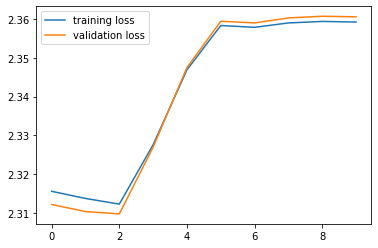

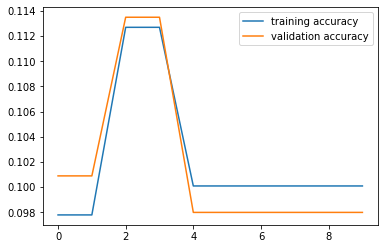

In [32]:
plt.figure()
plt.plot(train_losses,label='training loss')
plt.plot(val_losses,label='validation loss')
plt.legend()
plt.savefig('loss.png')
plt.figure()
plt.plot(train_accs,label='training accuracy')
plt.plot(val_accs,label='validation accuracy')
plt.legend()
plt.savefig('accuracy.png')

In [33]:
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).
